# Facies Classification Based on SEG Tutorial (2016)

#### T. Altay Sansal

Here I am using the open data under the SEG 2016 facies classification tutorial which can be found [here](https://github.com/seg/tutorials-2016/blob/master/1610_Facies_classification/).

There are 9 different facies there were classified using core analysis. They are labeled and numbered as following.

 1. Nonmarine sandstone: <b>SS</b>
 2. Nonmarine coarse siltstone: <b>CSiS</b>
 3. Nonmarine fine siltstone: <b>FSiS</b>
 4. Marine siltstone and shale: <b>SiSh</b>
 5. Mudstone (limestone): <b>MS</b>
 6. Wackestone (limestone): <b>WS</b>
 7. Dolomite: <b>D</b>
 8. Packstone-grainstone (limestone): <b>PS</b>
 9. Phylloid-algal bafflestone (limestone): <b>BS</b>

Let's import some functions we are using.

In [1]:
from os.path import join

from numpy import arange, array, insert
from scipy.signal import medfilt
from pandas import concat, read_csv, options, set_option

from sklearn import svm
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer, RobustScaler, StandardScaler

from matplotlib.pyplot import close, subplots, plot
from matplotlib import rcParams
import seaborn as sns

from globals import FACIES_LABELS, FACIES_COLORS
from visualization import compare_facies_plot, make_facies_log_plot
from classification_utilities import display_cm, display_adj_cm

# Set display parameters for pandas and matplotlib
set_option("display.max_rows", 10)
set_option('precision',4)
options.mode.chained_assignment = None
%matplotlib inline

print("Imported all functions successfully!")

Imported all functions successfully!


Now that we have the library functions we need, we can start reading and exploring the data.

For reading and organizing, I will be using Pandas. After reading, it will show example data and statistics.

In [2]:
file_path = join('data_input', 'facies_vectors.csv')

well_data = read_csv(file_path)
well_data.set_index('Well Name', inplace=True)

all_wells = well_data.index.unique()

# List names of files
print("There are %s wells in *.csv file:" % len(all_wells))
for well_name in all_wells:
    print("  - %s" % well_name)

# Add actual test labels to dataframe
well_data.loc[:,'FaciesLabels'] = well_data.apply(lambda row: FACIES_LABELS[(row['Facies'])], axis=1)

well_data

There are 10 wells in *.csv file:
  - SHRIMPLIN
  - ALEXANDER D
  - SHANKLE
  - LUKE G U
  - KIMZEY A
  - CROSS H CATTLE
  - NOLAN
  - Recruit F9
  - NEWBY
  - CHURCHMAN BIBLE


,Facies,Formation,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels
Well Name,,,,,,,,,,,
SHRIMPLIN,3,A1 SH,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000,FSiS
SHRIMPLIN,3,A1 SH,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979,FSiS
SHRIMPLIN,3,A1 SH,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957,FSiS
SHRIMPLIN,3,A1 SH,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936,FSiS
SHRIMPLIN,3,A1 SH,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915,FSiS
...,...,...,...,...,...,...,...,...,...,...,...
CHURCHMAN BIBLE,5,C LM,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685,MS
CHURCHMAN BIBLE,5,C LM,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677,MS
CHURCHMAN BIBLE,5,C LM,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669,MS


And to show stats:

In [6]:
well_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,3232.0000,4149.0000,4149.0000
mean,4.5033,2906.8674,64.9340,0.6596,4.4025,13.2011,3.7250,1.5184,0.5219
std,2.4743,133.3002,30.3025,0.2527,5.2749,7.1328,0.8962,0.4997,0.2866
min,1.0000,2573.5000,10.1490,-0.0259,-21.8320,0.5500,0.2000,1.0000,0.0000
25%,2.0000,2821.5000,44.7300,0.4980,1.6000,8.5000,3.1000,1.0000,0.2770
50%,4.0000,2932.5000,64.9900,0.6390,4.3000,12.0200,3.5515,2.0000,0.5280
75%,6.0000,3007.0000,79.4380,0.8220,7.5000,16.0500,4.3000,2.0000,0.7690
max,9.0000,3138.0000,361.1500,1.8000,19.3120,84.4000,8.0940,2.0000,1.0000


Now that I have access to the data, I will exclude one well for blind tests. I will also plot the blind well.

Note that all features have 4149 data points with the exception of PE. 

Rest of the wells will be used for training the model.

Training will be done with 9 wells:
  - SHRIMPLIN
  - ALEXANDER D
  - SHANKLE
  - LUKE G U
  - KIMZEY A
  - CROSS H CATTLE
  - NOLAN
  - Recruit F9
  - NEWBY


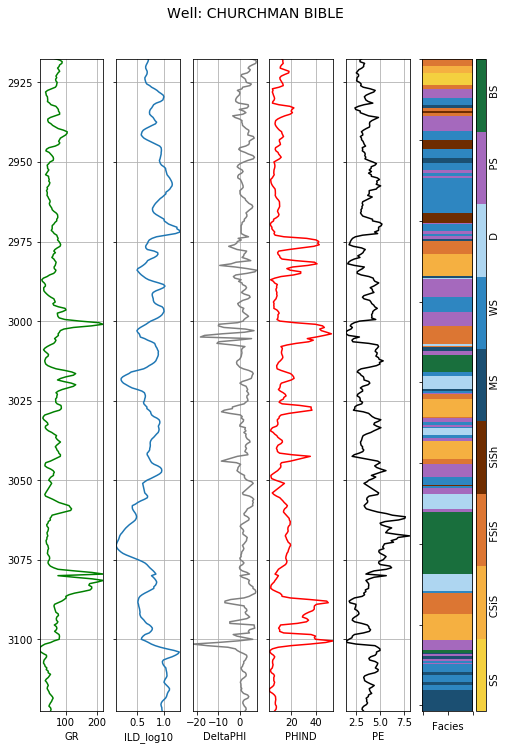

In [3]:
blind_well_orig = well_data.loc['CHURCHMAN BIBLE']
make_facies_log_plot(blind_well_orig, FACIES_COLORS)
training_data = well_data.drop('CHURCHMAN BIBLE')
training_wells = training_data.index.unique()

print("Training will be done with %s wells:" % len(training_wells))
for well_name in training_wells:
    print("  - %s" % well_name)

SS      260
CSiS    884
FSiS    729
SiSh    258
MS      266
WS      495
D       107
PS      611
BS      135
Name: Facies, dtype: int64

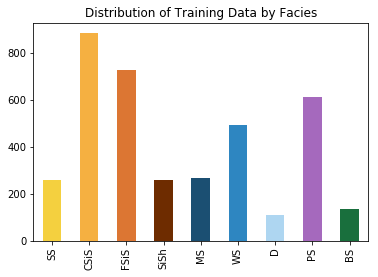

In [4]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = training_data['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = FACIES_LABELS.values()

fig = facies_counts.plot(kind='bar',color=FACIES_COLORS, 
                   title='Distribution of Training Data by Facies')

facies_counts

Training data has NaN values. We can quickly fix that by filling gaps with the mean. Not ideal, but will work.

In [5]:
PE_vals = training_data[['GR', 'PE']]

# Fill missing PE values with mean
imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)
imputer.fit(PE_vals)
PE_vals = imputer.transform(PE_vals)

# Put it back to dataframe
training_data['PE'] = PE_vals[:, 1]

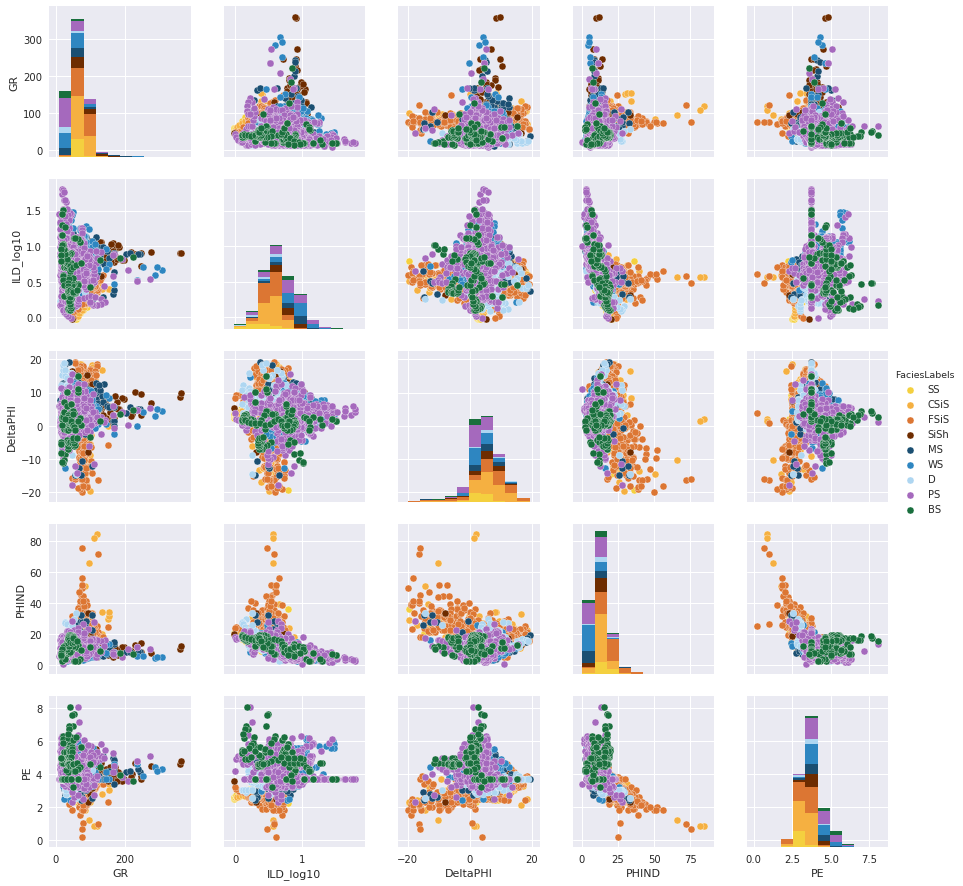

In [6]:
#save plot display settings to change back to when done plotting with seaborn
inline_rc = dict(rcParams)

sns.set()
sns.pairplot(training_data.drop(labels=['Facies','Formation','Depth','NM_M','RELPOS'], axis=1),
             hue='FaciesLabels', palette=FACIES_COLORS,
             hue_order=list(FACIES_LABELS.values()))

#switch back to default matplotlib plot style
rcParams.update(inline_rc)

Now that we took a look at the data, to make things more meaningful we augment features.

Here, the gradient of the feature vector is calculated with respect to depth for every well individually.

In [7]:
labels_and_features = training_data.drop(['Formation','FaciesLabels'], axis=1)

aug_feature_vectors = []

for well_name in training_wells:
    print("Augmenting %s well" %well_name)
    # Drop duplicates
    single_well = labels_and_features.loc[well_name].drop_duplicates()
    
    # Take all derivatives along rows
    d_single_well = single_well.diff(axis=0)
    
    # Divide all columns by the derivative along depth
    grad_single_well = d_single_well.drop(['Depth'], axis=1).div(d_single_well['Depth'], axis=0)
    
    # New labels for grad columns
    grad_single_well.columns = ['d_' + col for col in grad_single_well.columns]
    
    # Join all features and drop last sample because NaN, and also drop irrelevant features
    single_well = concat([single_well, grad_single_well.shift(-1)], axis=1)
#     single_well = single_well.drop(['d_GR', 'd_DeltaPHI', 'd_PHIND', 'd_PE', 'd_NM_M', 'd_RELPOS'], axis=1)
    aug_feature_vectors.append(single_well.dropna().drop(['Depth', 'd_Facies', 'd_RELPOS'], axis=1))

# Finally merge all wells in 1 dataframe and split features from labels
aug_feature_vectors = concat(aug_feature_vectors)
correct_facies_labels = aug_feature_vectors['Facies'].values
aug_feature_vectors = aug_feature_vectors.drop(['Facies'], axis=1)
aug_feature_vectors.describe()


Augmenting SHRIMPLIN well
Augmenting ALEXANDER D well
Augmenting SHANKLE well
Augmenting LUKE G U well
Augmenting KIMZEY A well
Augmenting CROSS H CATTLE well
Augmenting NOLAN well
Augmenting Recruit F9 well
Augmenting NEWBY well


,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,d_GR,d_ILD_log10,d_DeltaPHI,d_PHIND,d_PE,d_NM_M
count,3733.0000,3733.0000,3733.0000,3733.0000,3733.0000,3733.000,3733.0000,3733.0000,3.7330e+03,3733.0000,3733.0000,3733.0000,3733.0000
mean,64.9956,0.6485,4.7077,13.1266,3.7143,1.495,0.5199,0.0219,3.9131e-05,-0.0203,-0.0004,-0.0034,0.0031
std,29.7068,0.2516,5.3363,6.6543,0.7507,0.500,0.2853,20.8886,9.6198e-02,4.9531,4.8840,0.4597,0.3303
min,10.1490,-0.0259,-19.9000,0.5500,0.2000,1.000,0.0000,-297.0000,-6.9400e-01,-42.2000,-31.6000,-3.5700,-2.0000
25%,46.0630,0.4890,1.9000,8.6140,3.2280,1.000,0.2760,-5.8760,-3.8000e-02,-1.6300,-1.5000,-0.1920,0.0000
50%,65.3300,0.6240,4.7000,12.1700,3.7157,1.000,0.5240,0.5880,0.0000e+00,0.0000,0.0000,0.0000,0.0000
75%,79.9400,0.8030,7.9120,16.0250,4.0000,2.000,0.7650,6.5600,3.8000e-02,1.8000,1.4800,0.1380,0.0000
max,361.1500,1.8000,19.3120,84.4000,8.0940,2.000,1.0000,295.3600,9.0200e-01,36.8000,49.3000,4.2300,2.0000


Now we are splitting the data into the training and testing set for cross-validation.

Then a robust scaler is used for normalizing the data.

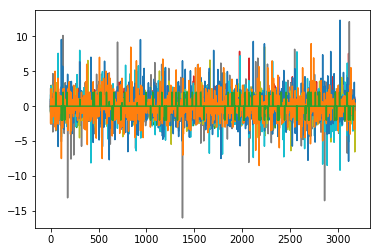

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
        aug_feature_vectors, correct_facies_labels, test_size=0.15, random_state=111)
scaler = RobustScaler(quantile_range=[20, 80]).fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Making sure all features are mean around 0
stats_check = plot(X_train)

In [17]:
# GPC
kernel = 1.0 * RBF([1.0])
clf = GaussianProcessClassifier(kernel=kernel, n_jobs=-1)

# SVM
clf = svm.SVC()

clf.fit(X_train,y_train)
predicted_labels = clf.predict(X_test)

conf = confusion_matrix(y_test, predicted_labels)

def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

adjacent_facies = array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

display_cm(conf, FACIES_LABELS.values(), hide_zeros=True, display_metrics=True)
print('** Facies classification accuracy (f1) = %f\n' % accuracy(conf))

display_adj_cm(conf, FACIES_LABELS.values(), adjacent_facies, hide_zeros=True, display_metrics=True)
print('** Facies classification accuracy (f1) = %f\n' % accuracy_adjacent(conf, adjacent_facies))

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    24    18                                              42
     CSiS     1   108    35                             1         145
     FSiS          29    75                                       104
     SiSh           1     3    23     1     8     1     4          41
       MS           1     1     7     1    24     1     7          42
       WS                 1     4          41     1    17          64
        D                                   1     6     7          14
       PS                 2     1     1    15     1    60          80
       BS                 1     1           3     2    18     3    28

Precision  0.96  0.69  0.64  0.64  0.33  0.45  0.50  0.53  1.00  0.63
   Recall  0.57  0.74  0.72  0.56  0.02  0.64  0.43  0.75  0.11  0.61
       F1  0.72  0.72  0.68  0.60  0.04  0.53  0.46  0.62  0.19  0.58
** Facies classification accuracy (f1) = 0.608929

     Pred    SS  CSiS  FSiS 

Now let's try the model on the blind well!

In [18]:
blind_labels_and_features = blind_well_orig.drop(['Formation','FaciesLabels'], axis=1)

# Drop duplicates
blind_single_well = blind_labels_and_features.drop_duplicates()

# Take all derivatives along rows
d_blind_single_well = blind_single_well.diff(axis=0)

# Divide all columns by the derivative along depth
grad_blind_single_well = d_blind_single_well.drop(['Depth'], axis=1).div(d_blind_single_well['Depth'], axis=0)

# New labels for grad columns
grad_blind_single_well.columns = ['d_' + col for col in grad_blind_single_well.columns]

# Join all features and drop last sample because NaN, and also drop irrelevant features
blind_single_well = concat([blind_single_well, grad_blind_single_well.shift(-1)], axis=1)
# blind_single_well = blind_single_well.drop(['d_GR', 'd_DeltaPHI', 'd_PHIND', 'd_PE', 'd_NM_M', 'd_RELPOS'], axis=1)
blind_aug_feature_vectors = blind_single_well.dropna().drop(['Depth', 'd_Facies', 'd_RELPOS'], axis=1)

# Finally merge all wells in 1 dataframe and split features from labels
correct_blind_facies_labels = blind_aug_feature_vectors['Facies'].values
blind_aug_feature_vectors = blind_aug_feature_vectors.drop(['Facies'], axis=1)
blind_aug_feature_vectors.describe()

X_blind = scaler.transform(blind_aug_feature_vectors)
predicted_blind_labels = clf.predict(X_blind)

conf = confusion_matrix(correct_blind_facies_labels, predicted_blind_labels)
display_cm(conf, FACIES_LABELS.values(), hide_zeros=True, display_metrics=True)
print('** Facies classification accuracy (f1) = %f\n' % accuracy(conf))

display_adj_cm(conf, FACIES_LABELS.values(), adjacent_facies, hide_zeros=True, display_metrics=True)
print('** Facies classification accuracy (f1) = %f\n' % accuracy_adjacent(conf, adjacent_facies))

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS           8                                               8
     CSiS          28    27     1                                  56
     FSiS           4    41     3                       3          51
     SiSh                      10           3                      13
       MS                 4     2          18           5          29
       WS                 1    13          61          12          87
        D                 1    18     1     2     2     9     1    34
       PS                 8     3          26          38          75
       BS                 1                            22    27    50

Precision  0.00  0.70  0.49  0.20  0.00  0.55  1.00  0.43  0.96  0.57
   Recall  0.00  0.50  0.80  0.77  0.00  0.70  0.06  0.51  0.54  0.51
       F1  0.00  0.58  0.61  0.32  0.00  0.62  0.11  0.46  0.69  0.48
** Facies classification accuracy (f1) = 0.513648

     Pred    SS  CSiS  FSiS 

/Users/tasansal/Downloads/github/logfacies/classification_utilities.py:11: RuntimeWarning: invalid value encountered in true_divide
  precision = np.diagonal(cm)/cm.sum(axis=0).astype('float')
/Users/tasansal/Downloads/github/logfacies/classification_utilities.py:13: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * (precision * recall) / (precision + recall)


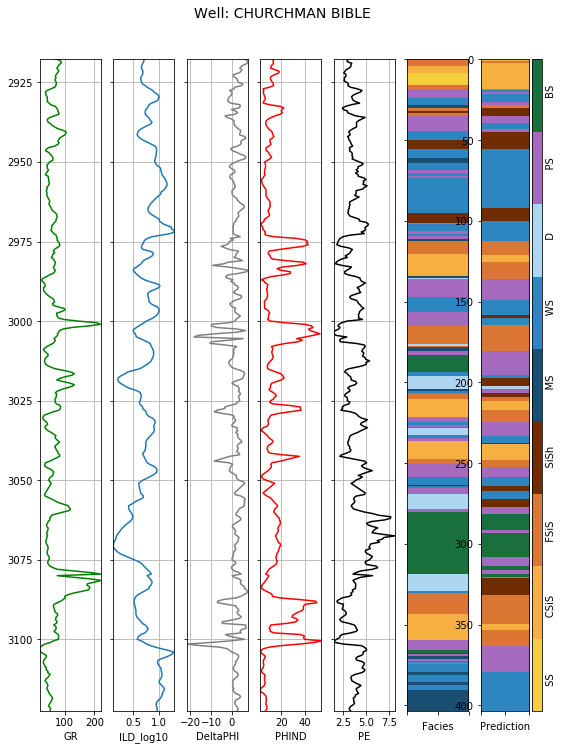

In [23]:
blind_well = blind_well_orig * 1
blind_well['Prediction'] = medfilt(insert(predicted_blind_labels, 0, 0), kernel_size=3)
blind_well['Well Name'] = blind_well_orig.index
compare_facies_plot(blind_well, 'Prediction', FACIES_COLORS)